In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.mixture import GaussianMixture
from sklearn.externals import joblib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
stations = pd.read_csv('../data/modelInput/stations.csv')
stations = stations.set_index('station_id')
stations.columns

Index(['station_name', 'latitude', 'longitude', 'first_used', 'last_used'], dtype='object')

In [3]:
#fit a Gaussian mixture model to the coordinates of all stations
cluster_number = 50
coords = stations[['latitude', 'longitude']].values
cluster_model = GaussianMixture(n_components=cluster_number)
cluster_model.fit(coords)
joblib.dump(cluster_model, '../models/gaussianMixtureModel.pkl') 

['../models/gaussianMixtureModel.pkl']

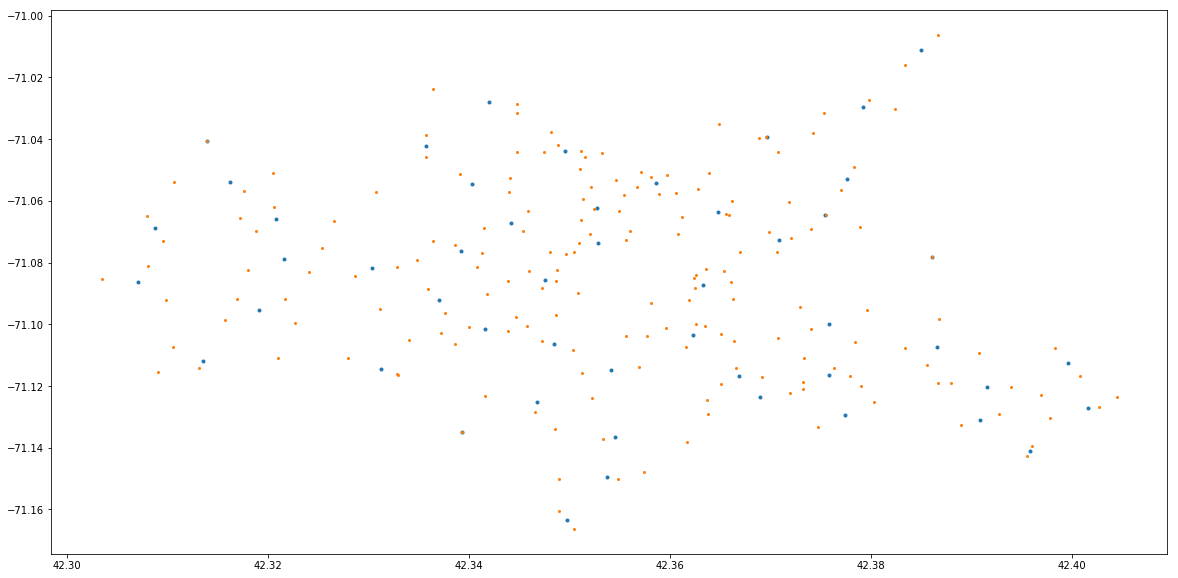

In [4]:
#plot stations and cluster centers 
plt.plot(cluster_model.means_[:, 0], cluster_model.means_[:, 1], '.', alpha = 1, markersize = 6)
plt.plot(coords[:, 0], coords[:, 1], '.', alpha = 1, markersize = 4)
plt.show()

In [5]:
trips = pd.read_csv('../data/modelInput/flowPerHourAndStation.csv')
trips.columns

Index(['date_hour', 'station_id', 'arrivals', 'departures', 'flow'], dtype='object')

In [6]:
#for each station, get its weight for each cluster 
weight_threshold = 1e-3
clustered_trips = pd.DataFrame([], columns=['date_hour', 'cluster_id', 'arrivals', 'departures'])

station_cluster_map = {}
for cluster_index in range(0, cluster_number):
    station_cluster_map[str(cluster_index)] = {}

station_iterator = stations.iterrows()
for row in station_iterator:
    station_id = row[0]
    station_weights = cluster_model.predict_proba(row[1][['latitude', 'longitude']].values.reshape(1, -1))[0]
    for cluster_index in range(0, cluster_number):
        weight = station_weights[cluster_index] 
        if(weight > weight_threshold):
            weighted_trips = trips[trips['station_id'] == station_id][['date_hour', 'arrivals', 'departures']]
            weighted_trips['arrivals'] = weighted_trips['arrivals'] * weight
            weighted_trips['departures'] = weighted_trips['departures'] * weight
            weighted_trips['cluster_id'] = cluster_index
            clustered_trips = clustered_trips.append(weighted_trips)
            station_cluster_map[str(cluster_index)][str(station_id)] = weight
            
clustered_trips = clustered_trips.groupby(['date_hour', 'cluster_id']).sum()
clustered_trips.to_csv('../data/modelInput/flowPerHourAndCluster.csv')

with open('../models/stationClusterMap.json', 'w') as f:
     json.dump(station_cluster_map, f)